#**ONCODE Masterclass: Introduction to machine learning in cancer genomics**
##November 18th, 2020
##**Deep Learning 1: Image Classification with a Convolutional Neural Network (CNN)**

You need to open this notebook in Google Colaboratory. Go to this link:

https://colab.research.google.com/github/UMCUGenetics/ONCODE_MC/blob/master/deep_learning_1/Deep%20Learning%20I%20-%20MNIST.ipynb

<img src='https://drive.google.com/uc?id=1gQU3ywndM16loOCb4k4AGklgXu0-yBwv'>

##Introduction for absolute beginners: main concepts in Deep Learning
Deep Learning is a class of machine learning algorithms inspired by the structure and function of the brain. At the basic level is the perceptron, the mathematical representation of a biological neuron. Just like in the human cortex, there can be several layers of interconnected perceptrons. Input values get passed through this “network” of hidden layers until they eventually converge to the output layer.
<center> 
<img src='https://drive.google.com/uc?id=1YKTC1-wasZywRT6hXCLyBMw8qgrKXRHf' width="450" height="220"/>
</center>

**Weights** and **biases** are learned parameters of a perceptron model. Weights control the signal (or the strength of the connection) between two neurons.  In other words, a weight decides how much influence the input will have on the output.
Biases, which are constant, are an additional input into the next layer that will always have the value of 1.  Bias units are not influenced by the previous layer (they do not have any incoming connections) but they do have outgoing connections with their own weights.  The bias unit guarantees that even when all the inputs are zeros there will still be an activation in the neuron.
An **activation function** (sigmoid on the above figure) acts as a mathematical ‘gateway’ which receives the input and calculates a weighted sum with added bias to determine if the node should fire or not. This allows some connections to become stronger, causing new connections to appear, or weaker, causing connections to be eliminated.
<center> 
<img src='https://drive.google.com/uc?id=1HYUFSGpX4pCMykKIq8p8-qyoseWk_yYl' width="430" height="220"/>
</center>

**How does the model learn weights and biases?**


**But why to choose Deep Learning instead of conventional machine learning algorithms?**

When dealing with large input data sizes with a long list of input values, machine learning algorithms typically require some feature selection prior to model training. The main advantage of deep learning models is that they do not necessarily need structured data and pre-obtained/selected features to classify the data. Deep learning models send the input through different layers of the network, with each network layer hierarchically defining specific features of the original input data.
<center> 
<img src='https://drive.google.com/uc?id=10mZ4aCmWrv56ymrPQI4llK_F4Nn3-JiX' width="490" height="300"/>
</center>

Moreover, deep learning models perform better in so-called 'big data' conditions, as they are well suited to learn complex feature patterns from large datasets and perform with higher accuracy on certain tasks (e.g.: image recognition/classification, speech recognition).

<center> 
<img src='https://drive.google.com/uc?id=12t2HoroX8Jf02a6IxsGzO-lzoWrpQ61T' width="450" height="300"/><br>copyright: Andrew Ng</br>
</center> 

## What are Convolutional Neural Networks (CNNs)?

D. H. Hubel and T. N. Wiesel proposed an explanation for the way in which mammals visually perceive the world around them using a layered architecture of neurons in the brain. In their hypothesis, within the visual cortex, complex functional responses generated by “complex cells” are constructed from more simplistic responses from “simple cells’. For instances, simple cells would respond to oriented edges etc, while complex cells will also respond to oriented edges but with a degree of spatial invariances.
<center> 
<img src='https://drive.google.com/uc?id=1026v3vAbACmAmCMIkVT8dh1AQY4t9UtT' width="720" height="240"/>
</center> 

This in turn inspired the architecture of deep convolutional neural networks, by the combination of **local connections, layering** and **spacial invariance (shifting the input signal)**.
Convolutional networks have been tremendously successful in practical applications where the input data has grid-like topology (e.g. images).
<center> 
<img src='https://drive.google.com/uc?id=189HShi0OjE2FXoxUdKdDsHS44YNG2_4S' width="720" height="320"/>
</center> 

## Overview of exercise
Now we are going to implement a CNN to classify handwritten digits of the MNIST dataset. The labeled dataset consists of 60000 images of size 28x28 = 784 pixels (one gray-scale number) including the corresponding labels from 0,..,9. Each image is normalized such that each pixel takes on values in the range [0,1]. <br>
</br>

This architecture will be implemented with Keras and TensorFlow. In order to prevent the network from overfitting during learning we implement dropout and data augmentation, i.e. new images are generated from the original ones via rotation, translation and zooming. We will also explore the application of cross-validation and meta-learning.
## Loading packages

In [83]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(25)

##Load data and have a look at it

In [84]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)
print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_test original shape (10000, 28, 28)
y_test original shape (10000,)


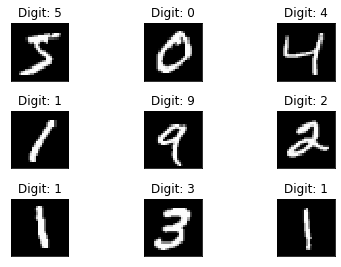

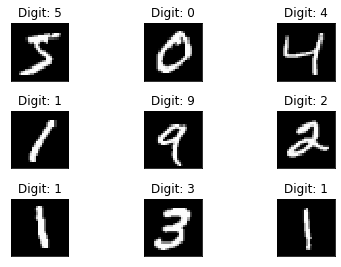

In [85]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Reshape digit images
mnist.load_data() supplies the MNIST digits with structure (number of samples, 28, 28) i.e. with 2 dimensions per example representing a greyscale image in 28x28.

However, we are going to work with 'Conv2D' layers in Keras which are designed to handle 3 dimensions per example. They have 4-dimensional inputs and outputs. This covers colour images (number of samples, number of channels, width, height), but more importantly, it covers deeper layers of the network, where each example has become a set of feature maps i.e. (number of samples, number of features, width, height).

The greyscale image for MNIST digits input would either need a different CNN layer design (or a parameter to the layer constructor to accept a different shape), or the design could simply use a standard CNN and you must explicitly express the examples as 1-channel images. In Keras, they chose the latter approach, which needs the re-shape.

In [86]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

X_train.shape

(60000, 28, 28, 1)

##One-hot encoding of image labels

In [87]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

##Building a basic CNN model

In [88]:
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [89]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_18 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_20 (Activation)   (None, 10, 10, 64)       

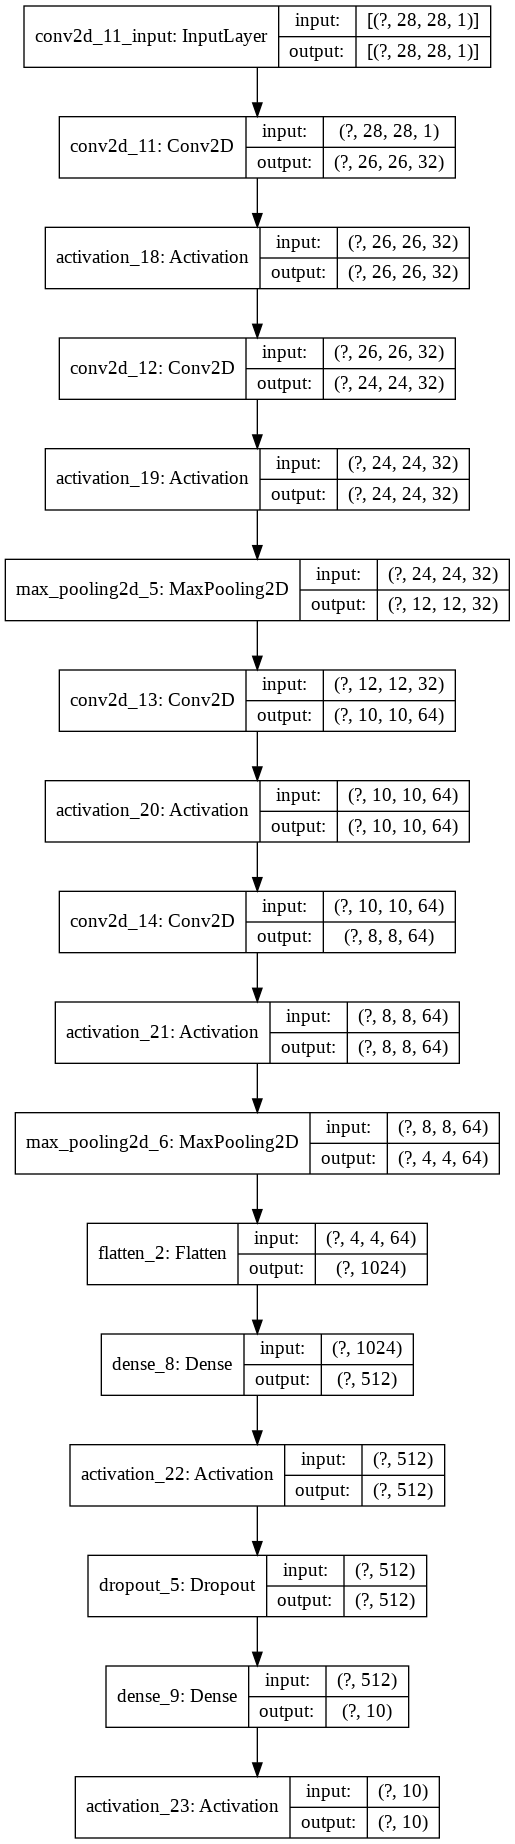

In [90]:
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

In [91]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [92]:
size = int(len(X_train) * 0.8)

train_x, val_x = X_train[:size], X_train[size:]
train_y, val_y = Y_train[:size], Y_train[size:]

In [93]:
history_basic = model.fit(train_x, train_y, batch_size=128, epochs=5, validation_data=(val_x, val_y))


Epoch 1/5
375/375 [==============================] - 3s 8ms/step - loss: 0.1915 - accuracy: 0.9414 - val_loss: 0.0617 - val_accuracy: 0.9814
Epoch 2/5
375/375 [==============================] - 3s 8ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.0367 - val_accuracy: 0.9889
Epoch 3/5
375/375 [==============================] - 3s 8ms/step - loss: 0.0321 - accuracy: 0.9898 - val_loss: 0.0368 - val_accuracy: 0.9901
Epoch 4/5
375/375 [==============================] - 3s 8ms/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.0268 - val_accuracy: 0.9922
Epoch 5/5
375/375 [==============================] - 3s 8ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0308 - val_accuracy: 0.9913


In [94]:
score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0268 - accuracy: 0.9912

Test accuracy:  0.9911999702453613


In [95]:
history_basic.history.keys() 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

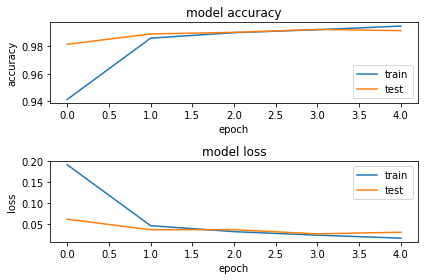

In [96]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_basic.history['accuracy'])
plt.plot(history_basic.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_basic.history['loss'])
plt.plot(history_basic.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

And finally we plot the confusion matrix:

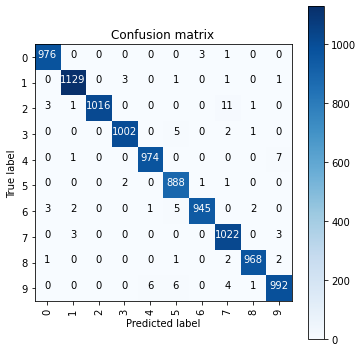

In [97]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(Y_test,axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, classes = [0,1,2,3,4,5,6,7,8,9]) 
plt.show()

##The next level: enhancing the training set with data augmentation

In [98]:
# rotations, translations, zoom
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
# get transformed images
test_gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

In [99]:
history_augmented = model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
937/937 [==============================] - 19s 21ms/step - loss: 0.0718 - accuracy: 0.9777 - val_loss: 0.0201 - val_accuracy: 0.9934
Epoch 2/5
937/937 [==============================] - 19s 20ms/step - loss: 0.0441 - accuracy: 0.9869 - val_loss: 0.0187 - val_accuracy: 0.9941
Epoch 3/5
937/937 [==============================] - 19s 20ms/step - loss: 0.0355 - accuracy: 0.9893 - val_loss: 0.0222 - val_accuracy: 0.9923
Epoch 4/5
937/937 [==============================] - 19s 21ms/step - loss: 0.0326 - accuracy: 0.9896 - val_loss: 0.0161 - val_accuracy: 0.9944
Epoch 5/5
937/937 [==============================] - 19s 20ms/step - loss: 0.0292 - accuracy: 0.9910 - val_loss: 0.0152 - val_accuracy: 0.9952


In [100]:
score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9952

Test accuracy:  0.995199978351593


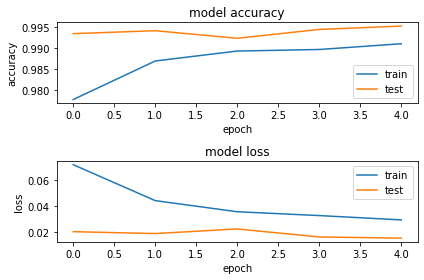

In [101]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

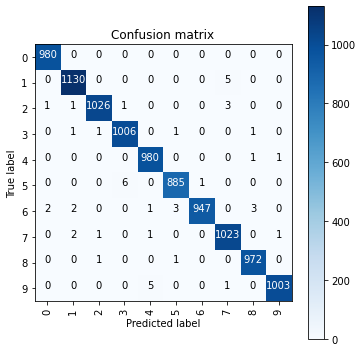

In [102]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(Y_test,axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, classes = [0,1,2,3,4,5,6,7,8,9]) 
plt.show()

## +1 Exercise: Stacking neural networks and training a meta-model in 10-fold cross-validation